In [1]:
# !ls adversarial-robustness-toolbox/
import os
os.chdir('/home/surthi/adversarial-robustness-toolbox/')

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import tensorflow as tf
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
from keras.regularizers import l2
import numpy as np
from art.attacks import DeepFool
from art.classifiers import KerasClassifier
from art.utils import load_dataset

Using TensorFlow backend.


In [3]:
def evaluate(clf, x_train, y_train, x_test, y_test):
    # train acc
    train_preds = np.argmax(clf.predict(x_train), axis=1)
    train_acc = np.sum(train_preds == np.argmax(y_train, axis=1)) / y_train.shape[0]
    # test acc
    test_preds = np.argmax(clf.predict(x_test), axis=1)
    test_acc = np.sum(test_preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("\nTraining and Test accuracies: %.2f %.2f%%" % (train_acc*100, test_acc*100))
    return train_acc, test_acc

def plot_curves(model, title='model accuracy and loss'):
    import matplotlib.pyplot as plt
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['loss'])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Loss'], loc='upper left')
    return plt

def save_clf(c, folder, clf_filename, model_filename):
    cwd = os.getcwd()
    os.chdir(folder)
    import pickle
    with open(clf_filename, "wb") as f:
        pickle.dump(c.__getstate__, f)
    c._model.save(model_filename)
    os.chdir(cwd)

DUMP_FOLDER = '/home/surthi/models/'
def pickle_dump(data, filename, folder=DUMP_FOLDER):
    cwd = os.getcwd()
    os.chdir(folder)
    import pickle
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    os.chdir(cwd)

def pickle_load(filename):
    import pickle
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_clf(folder, clf_filename, model_filename):
    cwd = os.getcwd()
    os.chdir(folder)
    import pickle
    with open(clf_filename, "rb") as f:
        clf_state = pickle.load(f)
    model = tf.keras.models.load_model(model_filename)
    os.chdir(cwd)
    clf = KerasClassifier(model=model)
    clf.__setstate__(clf_state())
    return clf, model

In [4]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

# CIFAR10 CNN MODEL

In [41]:
def get_vanilla_model(x_train, y_train, batch_norm=False):
#     os.chdir('/home/surthi')
#     _m = tf.keras.models.load_model('data/lid_model_cifar.h5')
    m = Sequential()

    m.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(Conv2D(32, (3, 3), padding='same'))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 5
    m.add(Conv2D(64, (3, 3), padding='same'))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(Conv2D(64, (3, 3), padding='same'))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 10
    m.add(Conv2D(128, (3, 3), padding='same'))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(Conv2D(128, (3, 3), padding='same'))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 15
    m.add(Flatten())
    m.add(Dropout(0.5))
    m.add(Dense(1024, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())

    # layer19
    m.add(Dropout(0.5))
    m.add(Dense(512, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
    m.add(Activation('relu'))
    if(batch_norm):
        m.add(BatchNormalization())
    m.add(Dropout(0.5))
    m.add(Dense(10))
    m.add(Activation('softmax'))
    m.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    c = KerasClassifier(model=m)
    c.fit(x_train, y_train, nb_epochs=50, batch_size=128)
#     os.chdir('/home/surthi/adversarial-robustness-toolbox/')
    return c

# CIFAR CNN WITH BATCHNORM

In [42]:
vanilla_clf_with_bn = get_vanilla_model(x_train, y_train, batch_norm=True)

Epoch 1/50
391/391 [==============================] - 34s 86ms/step - loss: 3.6753 - acc: 0.4431
Epoch 2/50
391/391 [==============================] - 28s 73ms/step - loss: 2.3651 - acc: 0.6351
Epoch 3/50
391/391 [==============================] - 28s 72ms/step - loss: 1.6466 - acc: 0.7142
Epoch 4/50
391/391 [==============================] - 28s 72ms/step - loss: 1.2835 - acc: 0.7549
Epoch 5/50
391/391 [==============================] - 28s 72ms/step - loss: 1.1075 - acc: 0.7800
Epoch 6/50
391/391 [==============================] - 28s 72ms/step - loss: 1.0145 - acc: 0.8007
Epoch 7/50
391/391 [==============================] - 28s 71ms/step - loss: 0.9608 - acc: 0.8188
Epoch 8/50
391/391 [==============================] - 28s 71ms/step - loss: 0.9270 - acc: 0.8310
Epoch 9/50
391/391 [==============================] - 28s 71ms/step - loss: 0.8644 - acc: 0.8447
Epoch 10/50
391/391 [==============================] - 28s 70ms/step - loss: 0.8407 - acc: 0.8538
Epoch 11/50
391/391 [========

In [45]:
evaluate(vanilla_clf_with_bn, x_train, y_train, x_test, y_test)


Training and Test accuracies: 98.15 82.28%


(0.98146, 0.8228)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

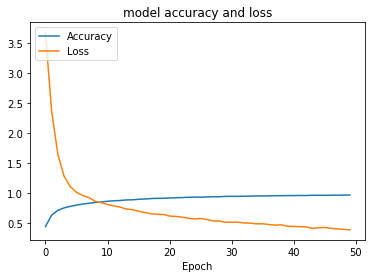

In [46]:
plot_curves(vanilla_clf_with_bn._model)

In [50]:
save_clf(vanilla_clf_with_bn, '/home/surthi/models/cifar10/', 'vanilla_clf_with_bn.h5', 'vanilla_clf_with_bn_model.h5')

In [4]:
c1_bn, model1_bn = load_clf('/home/surthi/models/cifar10/', 'vanilla_clf_with_bn.h5', 'vanilla_clf_with_bn_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# CIFAR CNN WITHOUT BATCHNORM

In [10]:
vanilla_clf = get_vanilla_model(x_train, y_train)

Epoch 1/50
391/391 [==============================] - 17s 43ms/step - loss: 2.0254 - acc: 0.3420
Epoch 2/50
391/391 [==============================] - 16s 40ms/step - loss: 1.4478 - acc: 0.5344
Epoch 3/50
391/391 [==============================] - 16s 40ms/step - loss: 1.2282 - acc: 0.6320
Epoch 4/50
391/391 [==============================] - 16s 40ms/step - loss: 1.1005 - acc: 0.6868
Epoch 5/50
391/391 [==============================] - 16s 40ms/step - loss: 1.0181 - acc: 0.7213
Epoch 6/50
391/391 [==============================] - 15s 40ms/step - loss: 0.9543 - acc: 0.7461
Epoch 7/50
391/391 [==============================] - 15s 40ms/step - loss: 0.9134 - acc: 0.7608
Epoch 8/50
391/391 [==============================] - 15s 40ms/step - loss: 0.8685 - acc: 0.7772
Epoch 9/50
391/391 [==============================] - 15s 40ms/step - loss: 0.8306 - acc: 0.7917
Epoch 10/50
391/391 [==============================] - 15s 40ms/step - loss: 0.8003 - acc: 0.8052
Epoch 11/50
391/391 [========


Training and Test accuracies: 97.93 81.64%


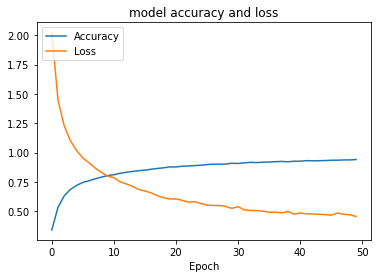

In [20]:
evaluate(vanilla_clf, x_train, y_train, x_test, y_test)
plot_curves(vanilla_clf._model)

In [53]:
save_clf(vanilla_clf, '/home/surthi/models/cifar10/', 'vanilla_clf.h5', 'vanilla_clf_model.h5')

In [5]:
c1, model1 = load_clf('/home/surthi/models/cifar10/', 'vanilla_clf.h5', 'vanilla_clf_model.h5')

In [6]:
evaluate(c1, x_train, y_train, x_test, y_test)


Training and Test accuracies: 97.93 81.64%


(0.97934, 0.8164)

# Generating Adversarials

In [10]:
def fgsm(clf, x_train, x_test, epsilon=0.1):
    from art.attacks.fast_gradient import FastGradientMethod
    epsilon = .1  # Maximum perturbation
    fgsm_adv_crafter = FastGradientMethod(clf, eps=epsilon)
    x_test_fgsm_adv = fgsm_adv_crafter.generate(x=x_test)
    x_train_fgsm_adv = fgsm_adv_crafter.generate(x=x_train)
    return x_train_fgsm_adv, x_test_fgsm_adv

def ifgsm(clf, x_train, x_test, epsilon=0.1, max_iter=10):
    from art.attacks.iterative_method import BasicIterativeMethod
    ifgsm_adv_crafter = BasicIterativeMethod(clf, eps=epsilon, eps_step=0.1, max_iter=max_iter)
    x_test_ifgsm_adv = ifgsm_adv_crafter.generate(x=x_test)
    x_train_ifgsm_adv = ifgsm_adv_crafter.generate(x=x_train)
    return x_train_ifgsm_adv, x_test_ifgsm_adv

x_train_fgsm_adv, x_test_fgsm_adv = fgsm(c1, x_train, x_test)
evaluate(c1, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)

x_train_ifgsm_adv, x_test_ifgsm_adv = ifgsm(c1, x_train, x_test)
evaluate(c1, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)


Training and Test accuracies: 13.68 17.07%

Training and Test accuracies: 0.42 4.39%


(0.00416, 0.0439)

In [11]:
x_train_deepfool_adv, x_test_deepfool_adv = deepfool(c1, x_train[:5000], x_test[:1000])
evaluate(c1, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.



Training and Test accuracies: 0.00 0.00%


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


(0.0, 0.0)

In [5]:
# pickle_dump((x_train, y_train,
#              x_test, y_test, 
#              x_train_fgsm_adv, x_test_fgsm_adv, 
#              x_train_ifgsm_adv, x_test_ifgsm_adv, 
#              x_train_deepfool_adv, x_test_deepfool_adv,
#              x_train_deepfool_adv_5to10, x_test_deepfool_adv_5to10,
#              x_train_cl2_adv, x_test_cl2_adv,
#              x_train_cl2_adv_5to10,x_test_cl2_adv_5to10), 
#             "vanilla_clf_adv_data.pkl", folder='/home/surthi/models/cifar10')

x_train, y_train,\
x_test, y_test,\
x_train_fgsm_adv, x_test_fgsm_adv, \
x_train_ifgsm_adv, x_test_ifgsm_adv,\
x_train_deepfool_adv, x_test_deepfool_adv, \
x_train_deepfool_adv_5to10, x_test_deepfool_adv_5to10, \
x_train_cl2_adv, x_test_cl2_adv, \
x_train_cl2_adv_5to10,x_test_cl2_adv_5to10, \
 = pickle_load('/home/surthi/models/cifar10/vanilla_clf_adv_data.pkl')



In [22]:
def deepfool(clf, x_train, x_test):
    from art.attacks import DeepFool
    deep_adv_crafter = DeepFool(clf)
    x_train_deepfool_adv = deep_adv_crafter.generate(x_train)
    x_test_deepfool_adv = deep_adv_crafter.generate(x_test)
    return x_train_deepfool_adv, x_test_deepfool_adv

def carlinil2(clf, x_train, x_test):
    from art.attacks import CarliniL2Method
    cl2_adv_crafter = CarliniL2Method(classifier=clf, targeted=False, max_iter=5)
    x_train_cl2_adv = cl2_adv_crafter.generate(x_train)
    x_test_cl2_adv = cl2_adv_crafter.generate(x_test)
    return x_train_cl2_adv, x_test_cl2_adv

In [19]:
x_train_cl2_adv, x_test_cl2_adv = carlinil2(c1, x_train[:5000], x_test[:1000])
evaluate(c1, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])


Training and Test accuracies: 2.46 10.90%


(0.0246, 0.109)

In [16]:
print("hi")

hi


In [15]:
x_train_cl2_adv_5to10, x_test_cl2_adv_5to10 = carlinil2(c1, x_train[5000:10000], x_test[1000:2000])
evaluate(c1, x_train_cl2_adv_5to10, y_train[5000:10000], x_test_cl2_adv_5to10, y_test[1000:2000])


Training and Test accuracies: 2.04 11.20%


(0.0204, 0.112)

# Evaluating Acc of Models against Attacks

In [109]:
train_acc, test_acc = evaluate(c1, x_train, y_train, x_test, y_test)
fgsm_train_acc, fgsm_test_acc = evaluate(c1, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc, ifgsm_test_acc = evaluate(c1, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)
df_train_acc, df_test_acc = evaluate(c1, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
df_train_acc_2, df_test_acc_2 = evaluate(c1, x_train_deepfool_adv_5to10, y_train[5000:10000], x_test_deepfool_adv_5to10, y_test[1000:2000])
cl2_train_acc, cl2_test_acc = evaluate(c1, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])
cl2_train_acc_2, cl2_test_acc_2 = evaluate(c1, x_train_cl2_adv_5to10, y_train[5000:10000], x_test_cl2_adv_5to10, y_test[1000:2000])



Training and Test accuracies: 97.93 81.64%

Training and Test accuracies: 13.68 17.07%

Training and Test accuracies: 0.42 4.39%

Training and Test accuracies: 8.24 14.90%

Training and Test accuracies: 8.06 15.40%

Training and Test accuracies: 2.46 10.90%

Training and Test accuracies: 2.04 11.20%


In [110]:
train_acc_bn, test_acc_bn = evaluate(c1_bn, x_train, y_train, x_test, y_test)
fgsm_train_acc_bn, fgsm_test_acc_bn = evaluate(c1_bn, x_train_fgsm_adv, y_train, x_test_fgsm_adv, y_test)
ifgsm_train_acc_bn, ifgsm_test_acc_bn = evaluate(c1_bn, x_train_ifgsm_adv, y_train, x_test_ifgsm_adv, y_test)
df_train_acc_bn, df_test_acc_bn = evaluate(c1_bn, x_train_deepfool_adv, y_train[:5000], x_test_deepfool_adv, y_test[:1000])
df_train_acc_2_bn, df_test_acc_2_bn = evaluate(c1_bn, x_train_deepfool_adv_5to10, y_train[5000:10000], x_test_deepfool_adv_5to10, y_test[1000:2000])
cl2_train_acc_bn, cl2_test_acc_bn = evaluate(c1_bn, x_train_cl2_adv, y_train[:5000], x_test_cl2_adv, y_test[:1000])
cl2_train_acc_2_bn, cl2_test_acc_2_bn = evaluate(c1_bn, x_train_cl2_adv_5to10, y_train[5000:10000], x_test_cl2_adv_5to10, y_test[1000:2000])


Training and Test accuracies: 98.15 82.28%

Training and Test accuracies: 17.61 18.21%

Training and Test accuracies: 2.99 5.60%

Training and Test accuracies: 96.66 82.70%

Training and Test accuracies: 96.82 81.00%

Training and Test accuracies: 96.36 82.70%

Training and Test accuracies: 96.86 80.30%


In [117]:
acc1 = (train_acc, df_train_acc, cl2_train_acc, fgsm_train_acc, ifgsm_train_acc)
test_acc1 = (test_acc, df_test_acc, cl2_test_acc, fgsm_test_acc, ifgsm_test_acc)
acc_bn1 = (train_acc_bn, df_train_acc_bn, cl2_train_acc_bn, fgsm_train_acc_bn, ifgsm_train_acc_bn)
test_acc_bn1 = (test_acc_bn, df_test_acc_bn, cl2_test_acc_bn, fgsm_test_acc_bn, ifgsm_test_acc_bn)

print(acc1, test_acc1, acc_bn1, test_acc_bn1)

(0.97934, 0.0824, 0.0246, 0.13678, 0.00416) (0.8164, 0.149, 0.109, 0.1707, 0.0439) (0.98146, 0.9666, 0.9636, 0.17614, 0.0299) (0.8228, 0.827, 0.827, 0.1821, 0.056)


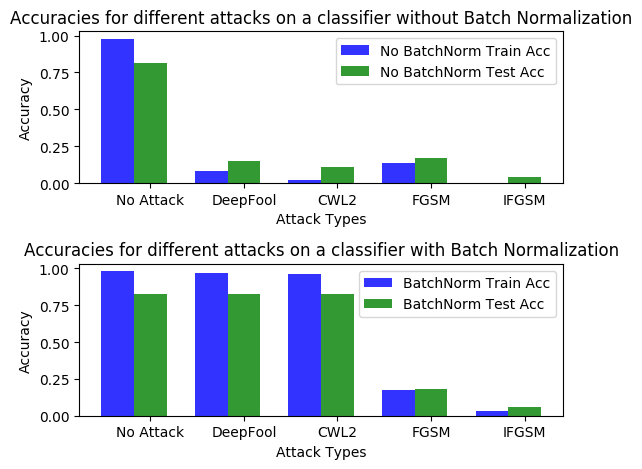

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 5

plt.subplot(2, 1, 1)
rects1 = plt.bar(index, acc1, bar_width,
alpha=opacity,
color='b',
label='No BatchNorm Train Acc')
rects2 = plt.bar(index + bar_width, test_acc1, bar_width,
alpha=opacity,
color='g',
label='No BatchNorm Test Acc')
plt.xlabel('Attack Types')
plt.ylabel('Accuracy')
plt.title('Accuracies for different attacks on a classifier without Batch Normalization')
plt.xticks(index + bar_width, ('No Attack', 'DeepFool', 'CWL2', 'FGSM', 'IFGSM'))
plt.legend()

plt.subplot(2, 1, 2)
rects3 = plt.bar(index, acc_bn1, bar_width,
alpha=opacity,
color='b',
label='BatchNorm Train Acc')
rects4 = plt.bar(index + bar_width, test_acc_bn1, bar_width,
alpha=opacity,
color='g',
label='BatchNorm Test Acc')

plt.xlabel('Attack Types')
plt.ylabel('Accuracy')
plt.title('Accuracies for different attacks on a classifier with Batch Normalization')
plt.xticks(index + bar_width, ('No Attack', 'DeepFool', 'CWL2', 'FGSM', 'IFGSM'))
plt.legend()

plt.tight_layout()
plt.show()

In [122]:
evaluate(c1, x_train_cl2_adv_5to10, y_train[5000:10000], x_test_cl2_adv_5to10, y_test[1000:2000])


Training and Test accuracies: 2.04 11.20%


(0.0204, 0.112)

In [23]:
x_train_deepfool_adv_5to10, x_test_deepfool_adv_5to10 = deepfool(c1, x_train[5000:10000], x_test[1000:2000])
evaluate(c1, x_train_deepfool_adv_5to10, y_train[5000:10000], x_test_deepfool_adv_5to10, y_test[1000:2000])


Training and Test accuracies: 8.06 15.40%


(0.0806, 0.154)

# DeepFool Robustness Metric

In [8]:
import numpy.linalg as la
def deepfool_robustness_metric(clf, x, y, x_adv):
    y_adv = clf.predict(x_adv)
    idxs = (np.argmax(y_adv, axis=1) != np.argmax(y, axis=1))
    if np.sum(idxs) == 0.0:
        return 0
    norm_type = 2
    perts_norm = la.norm((x_adv - x).reshape(x.shape[0], -1), ord=norm_type, axis=1)
    perts_norm = perts_norm[idxs]
    return np.mean(perts_norm / la.norm(x[idxs].reshape(np.sum(idxs), -1), ord=norm_type, axis=1))


In [9]:
dfm_df_train = deepfool_robustness_metric(c1, x_train[5000:10000], y_train[5000:10000], x_train_deepfool_adv_5to10)
# dfm_df_bn_train = deepfool_robustness_metric(c1_bn, x_train[5000:10000], y_train[5000:10000], x_train_deepfool_adv_5to10)

# dfm_df_test = deepfool_robustness_metric(c1, x_test[1000:2000], y_test[1000:2000], x_test_deepfool_adv_5to10)
# dfm_df_bn_test = deepfool_robustness_metric(c1_bn, x_test[1000:2000], y_test[1000:2000], x_test_deepfool_adv_5to10)

dfm_cl2_train = deepfool_robustness_metric(c1, x_train[5000:10000], y_train[5000:10000], x_train_cl2_adv_5to10)
# dfm_cl2_bn_train = deepfool_robustness_metric(c1_bn, x_train[5000:10000], y_train[5000:10000], x_train_cl2_adv_5to10)

# dfm_cl2_test = deepfool_robustness_metric(c1, x_test[1000:2000], y_test[1000:2000], x_test_cl2_adv_5to10)
# dfm_cl2_bn_test = deepfool_robustness_metric(c1_bn, x_test[1000:2000], y_test[1000:2000], x_test_cl2_adv_5to10)

dfm_fgsm_train = deepfool_robustness_metric(c1, x_train, y_train, x_train_fgsm_adv)
# dfm_fgsm_bn_train = deepfool_robustness_metric(c1_bn, x_train, y_train, x_train_fgsm_adv)

# dfm_fgsm_test = deepfool_robustness_metric(c1, x_test, y_test, x_test_fgsm_adv)
# dfm_fgsm_bn_test = deepfool_robustness_metric(c1_bn, x_test, y_test, x_test_fgsm_adv)

dfm_ifgsm_train = deepfool_robustness_metric(c1, x_train, y_train, x_train_ifgsm_adv)
# dfm_ifgsm_bn_train = deepfool_robustness_metric(c1_bn, x_train, y_train, x_train_ifgsm_adv)

# dfm_ifgsm_test = deepfool_robustness_metric(c1, x_test, y_test, x_test_ifgsm_adv)
# dfm_ifgsm_bn_test = deepfool_robustness_metric(c1_bn, x_test, y_test, x_test_ifgsm_adv)

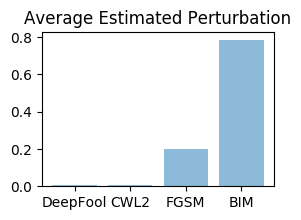

[0.006213735170364389, 0.006687116513650706, 0.2024410867641087, 0.7864765142137069]


In [46]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('DeepFool', 'CWL2', 'FGSM', 'BIM')
y_pos = np.arange(len(objects))
performance = [dfm_df_train, dfm_cl2_train, dfm_fgsm_train, dfm_ifgsm_train]

plt.figure(figsize=(3,2))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Average Estimated Perturbation')

plt.show()
fig.savefig('cifar10-avg-perturbation.png')
print(performance)

In [7]:
os.chdir('/home/surthi')
# _m = tf.keras.models.load_model('adversarial-robustness-toolbox/saved_models/cifar10_ResNet20v1_model.050.h5')
# _m_no_bn = tf.keras.models.load_model('adversarial-robustness-toolbox/saved_models/no_bn_cifar10_ResNet20v1_model.054.h5')
resnet_c, resnet_model = load_clf('/home/surthi/models/cifar10/', 'resnet_clf.h5', 'resnet_clf_model.h5')
resnet_bn_c, resnet_bn_model = load_clf('/home/surthi/models/cifar10/', 'resnet_clf_bn.h5', 'resnet_clf_model_bn.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


# CIFAR RESNET MODELS

In [3]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

_c_bn = KerasClassifier(model=model)
_c_bn.fit(x_train, y_train,
          batch_size=batch_size,
          nb_epochs=50,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

#     model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               shuffle=True,
#               callbacks=callbacks)


# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 32, 32, 16)   64          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_41

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
Learning rate:  0.001
1563/1563 [==============================] - 87s 56ms/step - loss: 1.4884 - acc: 0.5190 - val_loss: 1.3971 - val_acc: 0.5588

Epoch 00001: val_acc improved from -inf to 0.55880, saving model to /home/surthi/adversarial-robustness-toolbox/saved_models/cifar10_ResNet20v1_model.001.h5
Epoch 2/50
Learning rate:  0.001
1563/1563 [==============================] - 79s 50ms/step - loss: 1.0687 - acc: 0.6804 - val_loss: 1.7582 - val_acc: 0.5239

Epoch 00002: val_acc did not improve from 0.55880
Epoch 3/50
Learning rate:  0.001
1563/1563 [==============================] - 77s 50ms/step - loss: 0.8945 - acc: 0.7441 - val_loss: 0.9626 - val_acc: 0.7328

Epoch 00003: val_acc improved from 0.55880 to 0.73280, saving model to /home/surthi/adversarial-robustness-toolbox/saved_models/cifar10_ResNet20v1_model.003.h5
Epoch 4/50
Learning rate:  0.001
1563/1563 [==============================] - 79s 51ms/step - loss: 0.7931 -

1563/1563 [==============================] - 76s 49ms/step - loss: 0.4264 - acc: 0.9453 - val_loss: 1.3140 - val_acc: 0.7609

Epoch 00033: val_acc did not improve from 0.79330
Epoch 34/50
Learning rate:  0.001
1563/1563 [==============================] - 77s 49ms/step - loss: 0.4273 - acc: 0.9436 - val_loss: 1.1078 - val_acc: 0.7877

Epoch 00034: val_acc did not improve from 0.79330
Epoch 35/50
Learning rate:  0.001
1563/1563 [==============================] - 75s 48ms/step - loss: 0.4204 - acc: 0.9468 - val_loss: 1.1937 - val_acc: 0.7690

Epoch 00035: val_acc did not improve from 0.79330
Epoch 36/50
Learning rate:  0.001
1563/1563 [==============================] - 75s 48ms/step - loss: 0.4233 - acc: 0.9469 - val_loss: 1.3124 - val_acc: 0.7532

Epoch 00036: val_acc did not improve from 0.79330
Epoch 37/50
Learning rate:  0.001
1563/1563 [==============================] - 75s 48ms/step - loss: 0.4213 - acc: 0.9470 - val_loss: 1.1362 - val_acc: 0.7851

Epoch 00037: val_acc did not impro

In [10]:
save_clf(_c_bn, '/home/surthi/models/cifar10/', 'resnet_clf_bn.h5', 'resnet_clf_model_bn.h5')

In [10]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'no_bn_cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

    
_c = KerasClassifier(model=model)
_c.fit(x_train, y_train,
          batch_size=batch_size,
          nb_epochs=50,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)
#     model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                         validation_data=(x_test, y_test),
#                         steps_per_epoch = int(np.ceil(x_train.shape[0]/batch_size)),
#                         epochs=epochs, verbose=1, workers=4,
#                         callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Instructions for updating:
Colocations handled automatically by placer.
Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
Learning rate:  0.001
1563/1563 [==============================] - 52s 33ms/step - loss: 1.7963 - acc: 0.3768 - val_loss: 1.4674 - val_acc: 0.5030

Epoch 00001: val_acc improved from -inf to 0.50300, saving model to /home/surthi/adversarial-robustness-toolbox/saved_models/no_bn_cifar10_ResNet20v1_model.001.h5
Epoch 2/50
Learning rate:  0.001
1563/1563 [==============================] - 46s 30ms/step - loss: 1.3586 - acc: 0.5495 - val_loss: 1.2242 - val_acc: 0.6115

Epoch 00002: val_acc improved from 0.50300 to 0.61150, saving model to /home/surthi/adversarial-robustness-toolbox/saved_models/no_bn_cifar10_ResNet20v1_model.002.h5
Epoch 3/50
Learning rate:  0.001
1563/1563 [==============================] - 46s 29ms/step - loss: 1.1213 - acc: 


Epoch 00029: val_acc did not improve from 0.78550
Epoch 30/50
Learning rate:  0.001
1563/1563 [==============================] - 46s 29ms/step - loss: 0.4948 - acc: 0.9235 - val_loss: 1.1531 - val_acc: 0.7709

Epoch 00030: val_acc did not improve from 0.78550
Epoch 31/50
Learning rate:  0.001
1563/1563 [==============================] - 46s 29ms/step - loss: 0.4854 - acc: 0.9263 - val_loss: 1.1021 - val_acc: 0.7749

Epoch 00031: val_acc did not improve from 0.78550
Epoch 32/50
Learning rate:  0.001
1563/1563 [==============================] - 46s 30ms/step - loss: 0.4788 - acc: 0.9297 - val_loss: 1.1782 - val_acc: 0.7800

Epoch 00032: val_acc did not improve from 0.78550
Epoch 33/50
Learning rate:  0.001
1563/1563 [==============================] - 46s 30ms/step - loss: 0.4810 - acc: 0.9292 - val_loss: 1.1289 - val_acc: 0.7783

Epoch 00033: val_acc did not improve from 0.78550
Epoch 34/50
Learning rate:  0.001
1563/1563 [==============================] - 46s 30ms/step - loss: 0.4741 -

In [11]:
save_clf(_c, '/home/surthi/models/cifar10/', 'resnet_clf.h5', 'resnet_clf_model.h5')